#### validation dataset generation   

In [2]:
import torch
import numpy as np 
from glob import glob 
import rasterio as rio
import geopandas as gpd
from utils.imgShow import imsShow 
from utils.img2patch import img2patch


In [3]:
dir_scene = 'data/dset/scene/'
dir_dem = 'data/dset/dem/'
dir_truth = 'data/dset/truth/' 


In [5]:
## valset
ids_val_gdf = gpd.read_file('data/dset/dset_val.gpkg')
ids_val = ids_val_gdf['id_scene'].tolist()
paths_scene_val = [dir_scene+id+'_nor.tif' for id in ids_val]
paths_dem_val = [dir_dem+id+'_dem_nor.tif' for id in ids_val]
paths_truth_val = [dir_truth+id+'.tif' for id in ids_val]


In [6]:
paths_valset = list(zip(paths_scene_val, paths_dem_val, paths_truth_val))
paths_valset[1]


('data/dset/scene/l5_scene_05_nor.tif',
 'data/dset/dem/l5_scene_05_dem_nor.tif',
 'data/dset/truth/l5_scene_05.tif')

In [7]:
'''generate validation patches (include patch,dem,truth)'''
paths_valset = list(zip(paths_scene_val, paths_dem_val, paths_truth_val))
dset_list = []
for path_scene, path_dem, path_truth in paths_valset:
    scene_val_arr = rio.open(path_scene).read()
    dem_val_arr = rio.open(path_dem).read()
    truth_val_arr = rio.open(path_truth).read(1)
    scene_dem_truth_arr = np.concatenate([scene_val_arr, 
                                        dem_val_arr, 
                                        truth_val_arr[np.newaxis, ...]], 
                                        axis=0)
    img2patches = img2patch(img = scene_dem_truth_arr.transpose(1,2,0), 
                            patch_size = 256, 
                            edge_overlay = 40)
    patch_list = img2patches.toPatch()
    dset_list.extend(patch_list)
    break 
print(len(dset_list))


81


In [8]:
'''---- save validation data (patch, dem, truth)----'''
dir_valset = 'data/dset/valset'
for id_patch, patch_pdem_ptruth in enumerate(dset_list):
    print(id_patch)
    ## save as float16 to save space
    patch_ = torch.from_numpy(patch_pdem_ptruth).to(dtype=torch.float16)  
    path_save = dir_valset+'/patch_pdem_ptruth_'+ str(id_patch).rjust(4,'0')+'.pt'
    print(path_save)
    torch.save((patch_), path_save)
    break 


0
data/dset/valset/patch_pdem_ptruth_0000.pt


### load data and check

In [9]:
## load data
paths_patch_valset = sorted(glob(dir_valset + '/*'))
patch_list_valset = [torch.load(path, weights_only=True) for path in paths_patch_valset]
print(len(patch_list_valset))


1959


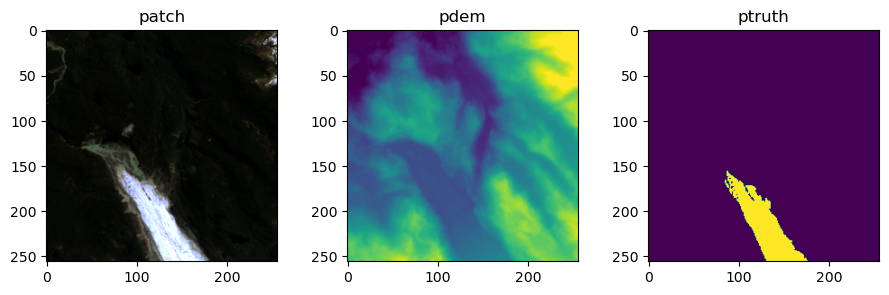

In [10]:
id = np.random.randint(0, len(patch_list_valset))
patch_pdem_ptruth = patch_list_valset[id].numpy() ##(patches,pdem,ptruth)
patch = patch_pdem_ptruth[:,:,0:6].astype(np.float32)
pdem = patch_pdem_ptruth[:,:,6:7].astype(np.float32)  
ptruth = patch_pdem_ptruth[:, :, -1:].astype(np.int8)  
patch_pdem_ptruth_ = [patch, pdem, ptruth]  
imgs_name = ['patch', 'pdem', 'ptruth']  
clip_list = [2,2,0]  
col_bands_list = [(2,1,0), (0,0,0), (0,0,0)]
imsShow(img_list=patch_pdem_ptruth_, 
            img_name_list=imgs_name,
            clip_list=clip_list, 
            color_bands_list=col_bands_list,
            figsize=(11,3))
